In [47]:
%matplotlib inline

import sys
import os
import numpy as np
import pandas as pd
import xarray as xr

import matplotlib
from matplotlib import pyplot as plt, animation, rc,colors
from datetime import datetime, timedelta
from cartopy import crs, feature
import cmocean
import yaml

from IPython.display import Image
rc('animation', html='html5')

sys.path.append('/home/jvalenti/MOAD/analysis-jose/Source')
from OP_functions import *

In [48]:
# surf=xr.open_dataset(paths['mask'],decode_times=False).coast_mask[0,1,:,:]
# fig,ax=plt.subplots(1,1,figsize=(5,10))
# ax.contour(surf)
# ax.set_aspect(1/np.sin(np.deg2rad(49)))

In [49]:
# Define paths
local = 0 #Set to 0 when working on server
paths = path(local)
config='/home/jvalenti/MOAD/analysis-jose/OParcels/beach100.yaml'

In [50]:
param = load_config1(config)
start = datetime(param['startdate']['year'], param['startdate']['month'], param['startdate']['day']) #Start date
Tmax = param['param']['length'] # Set Time length [days] 
duration = timedelta(days=Tmax)
dt = param['param']['dt'] #toggle between - or + to pick backwards or forwards 
N = param['param']['N'] # number of deploying locations
n = param['param']['n'] # 1000   # number of particles per location
dmin = param['param']['dmin'] #minimum depth
dd = param['param']['dd'] #max depth difference from dmin
name = param['file']['name'] #name output file

#WS = param['particle']['Ws']

daterange = [start+timedelta(days=i) for i in range(Tmax)]
fn =  name + '_'.join(d.strftime('%Y%m%d')+'_1n' for d in [start, start+duration]) + '.nc'
outfile = os.path.join(paths['out'], fn)

In [51]:
Dat=xr.open_dataset(paths['coords'],decode_times=False)
outf_lat=Dat['nav_lat'][445,304]
outf_lon=Dat['nav_lon'][445,304]
clon, clat = [float(outf_lon)],[float(outf_lat)]

In [52]:
coords = xr.open_dataset(paths['coords'], decode_times=False)
mask = xr.open_dataset(paths['mask'])
ds = xr.open_dataset(outfile)

In [53]:
np.nanmax(list(ds.dz))

0.0

In [54]:
#ds = xr.open_dataset('/results2/SalishSea/nowcast-green.201905/01jun21/SalishSea_1d_20210601_20210601_ptrc_T.nc')

In [55]:
DS=ds.to_dataframe()

DSsed=DS[DS.beached==3.0]
DSbe=DS[DS.beached==1.0]
DScol=DS[DS.beached==0.0]

Sedlon=np.array(DSsed.iloc[:,3])#.sort_values(by='time')
Seddepth=np.array(DSsed.iloc[:,4])#.sort_values(by='time')
Sedlat=np.array(DSsed.iloc[:,2])#.sort_values(by='time')

Belon=np.array(DSbe.iloc[:,3])#.sort_values(by='time')
Belat=np.array(DSbe.iloc[:,2])#.sort_values(by='time')

Collon=np.array(DScol.iloc[:,3])#.sort_values(by='time')
Collat=np.array(DScol.iloc[:,2])#.sort_values(by='time')

In [56]:
def distancia(lat2,lon2):
    R = 6371e3
    la1 = float(outf_lat) * math.pi/180
    la2 = lat2 * math.pi/180
    deltlat = (lat2-float(outf_lat)) * math.pi/180
    deltlon = (lon2-float(outf_lon)) * math.pi/180
    a = np.sin(deltlat/2) * np.sin(deltlat/2) + np.cos(la1) * np.cos(la2) * np.sin(deltlon/2) * np.sin(deltlon/2)
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    return R * c 
dcol = distancia(Collat,Collon)
dsink = distancia(Sedlat,Sedlon)
dbeach = distancia(Belat,Belon)

In [57]:
#countime = [] 
#for t in time:
#    countime.append(len(DScol.time[DScol.time==t]))
#np.savetxt("time_2.csv", countime, delimiter=",")
countime=np.genfromtxt('time0.csv', delimiter=',')
countime1=np.genfromtxt('time1.csv', delimiter=',')
countime2=np.genfromtxt('time_2.csv', delimiter=',')

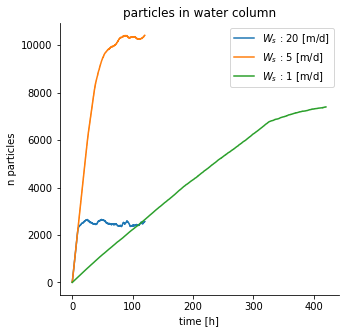

In [58]:
Time=np.linspace(0,120,28810)
Time2=np.linspace(0,420,10082)
fig,ax=plt.subplots(1,figsize=(5,5))
plt.plot(Time,countime,label='$W_s$ : 20 [m/d]')
plt.plot(Time,countime1,label='$W_s$ : 5 [m/d]')
plt.plot(Time2,countime2,label='$W_s$ : 1 [m/d]')
plt.legend()
plt.xlabel('time [h]')
plt.ylabel('n particles')
plt.title('particles in water column')
# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

Text(0.5, 1.0, 'Particles beached')

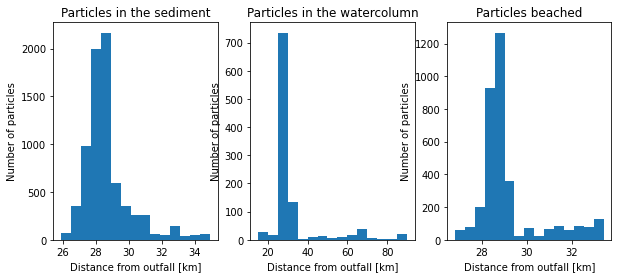

In [59]:
fig,axs=plt.subplots(1,3,figsize=(10,4))
axs[0].hist(dsink/1e3, bins = 15)
axs[0].set_xlabel('Distance from outfall [km]')
axs[0].set_ylabel('Number of particles')
axs[0].set_title('Particles in the sediment')

axs[1].hist(dcol/1e3, bins = 15)
axs[1].set_xlabel('Distance from outfall [km]')
axs[1].set_ylabel('Number of particles')
axs[1].set_title('Particles in the watercolumn')

axs[2].hist(dbeach/1e3, bins = 15)
axs[2].set_xlabel('Distance from outfall [km]')
axs[2].set_ylabel('Number of particles')
axs[2].set_title('Particles beached')

In [60]:
5.075e-05*500**1.33

0.19727232012297968

Text(0.05, 0.5, 'Latitude')

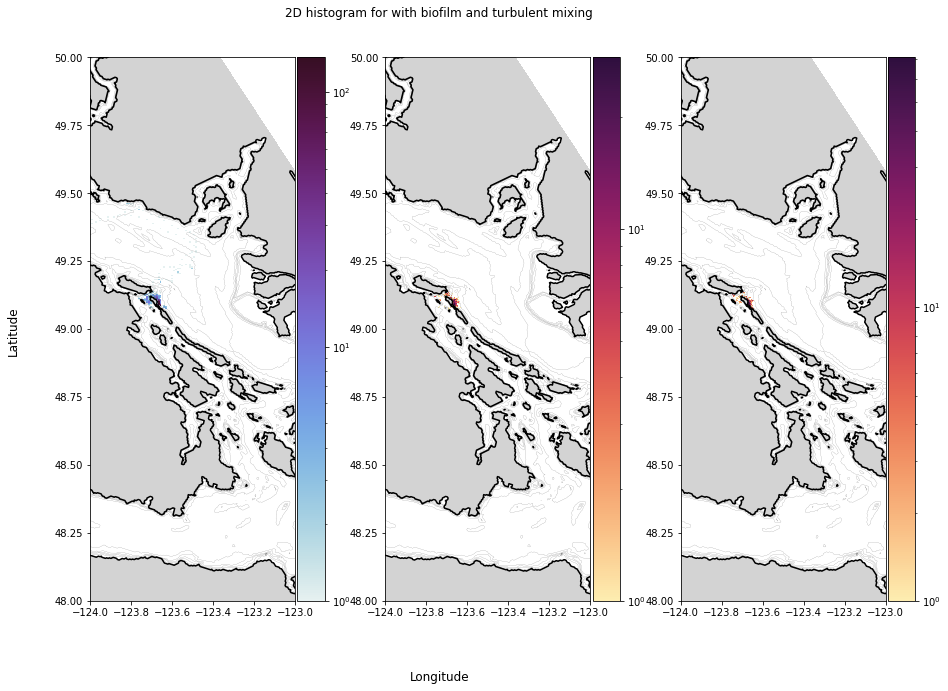

In [61]:
cm = cmocean.cm.dense

fig, [ax1,ax2,ax3] = plt.subplots(1,3,figsize=(15, 10))
ax1.contour(coords.nav_lon, coords.nav_lat, mask.mbathy[0,:,:],colors='k',linewidths=0.1)
ax1.contourf(coords.nav_lon, coords.nav_lat, mask.tmask[0, 0, ...], levels=[-0.01, 0.01], colors='lightgray')
ax1.contour(coords.nav_lon, coords.nav_lat, mask.tmask[0, 0, ...], levels=[-0.01, 0.01], colors='k')

ax2.contour(coords.nav_lon, coords.nav_lat, mask.mbathy[0,:,:],colors='k',linewidths=0.1)
ax2.contourf(coords.nav_lon, coords.nav_lat, mask.tmask[0, 0, ...], levels=[-0.01, 0.01], colors='lightgray')
ax2.contour(coords.nav_lon, coords.nav_lat, mask.tmask[0, 0, ...], levels=[-0.01, 0.01], colors='k')

ax3.contour(coords.nav_lon, coords.nav_lat, mask.mbathy[0,:,:],colors='k',linewidths=0.1)
ax3.contourf(coords.nav_lon, coords.nav_lat, mask.tmask[0, 0, ...], levels=[-0.01, 0.01], colors='lightgray')
ax3.contour(coords.nav_lon, coords.nav_lat, mask.tmask[0, 0, ...], levels=[-0.01, 0.01], colors='k')


aa=ax1.hist2d(Collon,Collat,100,norm = colors.LogNorm(), cmap =cm)
cb2=fig.colorbar(aa[3],ax=ax1,pad=0.01)
cb2.ax.get_yaxis().labelpad = 15
ax1.set_xlim([-124,-123])
ax1.set_ylim([48,50])


aa2=ax2.hist2d(Sedlon,Sedlat,100,norm = colors.LogNorm(), cmap =cmocean.cm.matter)
ax2.set_xlim([-124,-123])
ax2.set_ylim([48,50])
cb2=fig.colorbar(aa2[3],ax=ax2,pad=0.01)
cb2.ax.get_yaxis().labelpad = 15

aa=ax3.hist2d(Belon,Belat,50,norm = colors.LogNorm(), cmap =cmocean.cm.matter)
cb2=fig.colorbar(aa[3],ax=ax3,pad=0.01)
cb2.ax.get_yaxis().labelpad = 15
ax3.set_xlim([-124,-123])
ax3.set_ylim([48,50])

#ax1.set_xticks(np.arange(-125, -122, step=1))
#ax2.set_xticks(np.arange(-125, -122, step=1))
#ax3.set_xticks(np.arange(-125, -122, step=1))
ax1.set_aspect(1/np.sin(np.deg2rad(49)))
ax2.set_aspect(1/np.sin(np.deg2rad(49)))
ax3.set_aspect(1/np.sin(np.deg2rad(49)))


fig.suptitle(f'2D histogram for with biofilm and turbulent mixing',y=0.95,x=0.45)
fig.supxlabel('Longitude',x=0.45)
fig.supylabel('Latitude',x=0.05)
#plt.savefig("/home/jvalenti/MOAD/2dhist.pdf")

In [62]:
DS=ds.to_dataframe()
dss=DS[DS.beached==0]## In the water column
dssla=np.array(dss.lat)
dsslo=np.array(dss.lon)
dsscon= np.array(dss.tau)
dssdep=np.array(dss.z)

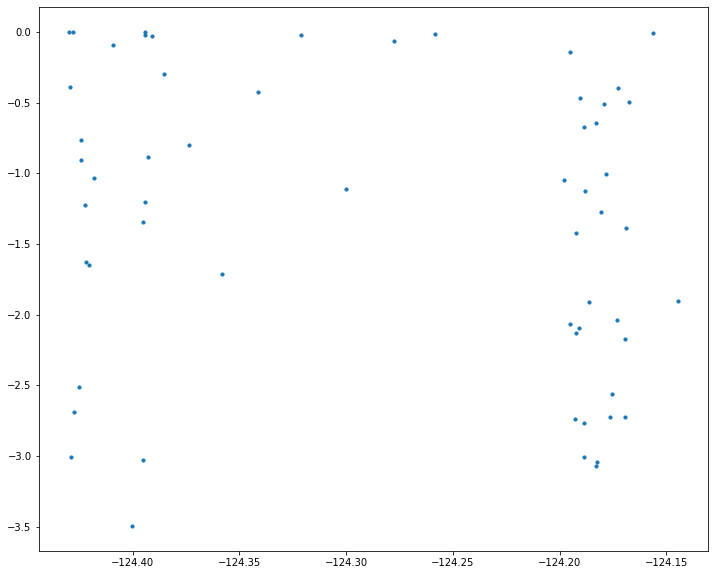

In [63]:
# #Green Particles are on the sediment
fig, axs = plt.subplots(1,figsize=(12, 10))
#ax = fig.add_subplot(projection='3d')
#visuald(axs[:,0],outfile,N,n,clon,clat,dmin,dd,300,301,local)
#visuald(fig,axs[:,1],outfile,N,n,clon,clat,dmin,dd,5039,5040,local)
nmin=-30
nmax=-1
coords,mask,ds = output(outfile,local)
ds0=ds.where(ds.time<=ds.time[0,nmax])
ds2=ds0.where(ds0.time>=ds0.time[0,nmin])
dss=ds2.where(ds2.beached==1)
dsc=ds2.where(ds2.beached==0)
dsb=ds2.where(ds2.beached==2)
zc=np.array(-dss.z[:, 0:-1])
zc = zc[~np.isnan(zc)]
axs.scatter(dsc.lon[:, 0:-1] ,-dsc.z[:, 0:-1],s=10,zorder=2)
#plt.plot(dss.lon[:,0:-1],)
#fig.suptitle(f'Particle location for  biofilm and turbulent mixing',y=0.95,x=0.45)
#fig.supxlabel('Longitude',x=0.45)
#axs.set_xlim([10000,12000])
#ax.set_ylim([47.9,50.5])
#ax.set_zlim([-400,0])

In [64]:
# import plotly.graph_objects as go
# import plotly.express as px

# z = np.array(-mask.mbathy[0,:,:]).flatten(order='C')
# #sh_0, sh_1 = z.shape
# #x, y = np.linspace(-125.5,-122, sh_1), np.linspace(47.9,50.5, sh_0)
# x = np.array(coords.glamt).flatten(order='C')
# y = np.array(coords.gphit).flatten(order='C')

# fig = go.Figure(data=[go.Surface(z=z, x=x, y=y,colorscale='deep',reversescale=True)])

# fig.update_traces(contours_z=dict(show=True, usecolormap=True,
#                                 project_z=True))
# fig.update_layout(title='Salish Sea Bathymetry',xaxis_title="Longitude", 
#                   yaxis_title="Latitude",autosize=False,
#                   width=900, height=900, 
#                   margin=dict(l=65, r=50, b=65, t=90))
# fig.update_layout(scene = dict(
#                     xaxis_title='Longitude',
#                     yaxis_title='Latitude',
#                     zaxis_title='Elevation'),
#                     margin=dict(r=60, b=60, l=60, t=60))  
# # fig.update_layout(color='Elevation')
# fig.update_layout(coloraxis_colorbar=dict(
#     title="Elevation",
#     thicknessmode="pixels", thickness=50,
#     lenmode="pixels", len=200,
#     yanchor="top", y=1,
#     ticks="outside", ticksuffix="",
#     dtick=5
# ))
# fig.update_layout(scene_aspectmode='manual',
#                   scene_aspectratio=dict(x=1, y=1, z=0.1))

# DSS=dss.to_dataframe()
# DSS=DSS[DSS.beached==3]

# #fig.add_scatter3d(z = -DSS.z/10,x=DSS.lon, y=DSS.lat, mode='markers', 
# #                   marker=dict(size=2))
# fig.show()

In [65]:
#profile(N,n,100,outfile,local)

In [66]:
# anim=mapanimationd(outfile,N,n,clon,clat,24,0)
# f = r"/home/jvalenti/MOAD/animations/fibreS1.gif" 
# FFwriter = animation.FFMpegWriter()
# anim.save(f, writer = FFwriter)

In [67]:
def mapanimation(outfile,N,n,clon,clat,fps=1,local=1):
    '''mapanimation(outfile,N,n,clon,clat,fps=1,local=1)
    Use this function to return an animated map of the particles,
    keep local=1 when working local and = 0 when remote. 
    outfile is the name of the output file from OP
    N= number of deploying sites,n=number of particles oper location,
    clat,clon location of deploying locations.
    '''
    coords,mask,ds = output(outfile,local)
    fig = plt.figure(figsize=(19, 8))
    ax = plt.axes(xlim=(-127,-121),ylim=(46.8,51.2))
    ax.contour(coords.nav_lon, coords.nav_lat, mask.mbathy[0,:,:],colors='k',linewidths=0.1)
    ax.contourf(coords.nav_lon, coords.nav_lat, mask.tmask[0, 0, ...], levels=[-0.01, 0.01], colors='lightgray')
    ax.contour(coords.nav_lon, coords.nav_lat, mask.tmask[0, 0, ...], levels=[-0.01, 0.01], colors='k')
    ax.grid()
    ax.set_aspect(1/1)
    plt.ylabel('Latitude',fontsize=16)
    plt.xlabel('Longitude',fontsize=16)
    t = ax.text(0.02, 0.02, '', transform=ax.transAxes)
    t.set_text('')
    ss = []#scatter_particles(ax, N,n, 0,0, ds.lat,ds.lon)
    sed= {0: "w", 1: "k"}

    def update(frame):
        tstamp = ds.time[0, frame].values.astype('datetime64[s]').astype(datetime)
        t.set_text(f'particle age: {frame/24:.2f} days')
        global ss
        for scat in ss:
            scat.remove()
        ss = scatter_particles(ax, N,n, frame,frame, ds.lat,ds.lon)
        #ss.append(ax.scatter(ds.lon[:,frame], ds.lat[:,frame],c='m',s=5,alpha=ds.beached[:,frame].fillna(0))/3)
        #ss.append(ax.scatter(clon,clat,c='r', marker='*', linewidths=2))
        return ss
    return animation.FuncAnimation(fig, update, frames=np.arange(0,len(ds.lon[0,:]),fps))

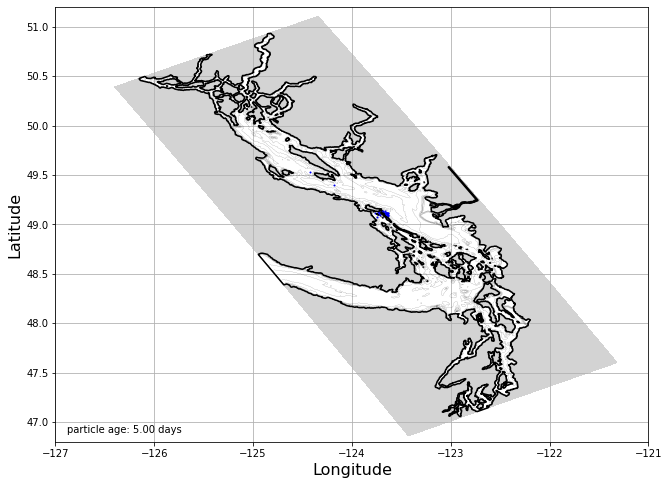

In [68]:
fps=15
anim = mapanimation(outfile,N,n,clon,clat,fps,local)
f = r"/home/jvalenti/MOAD/animations/fibreS1.gif" 
FFwriter = animation.FFMpegWriter()
anim.save(f, writer = FFwriter)

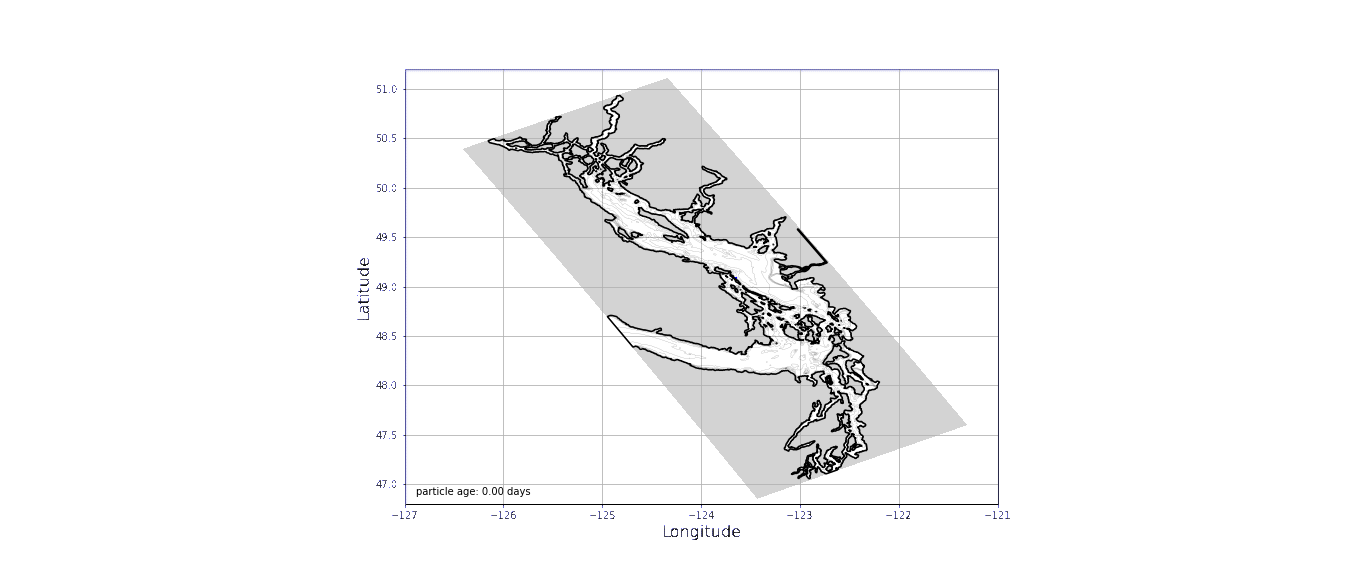

In [69]:
with open(f,'rb') as anim:
  display(Image(anim.read()))